In [48]:
#s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [49]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210/training_scores_epoch_Objectdump_20190906_075654_6a9ddeeb-bb15-41d3-946c-d2603bbeb04b.json to temp/training_scores_epoch_Objectdump_20190906_075654_6a9ddeeb-bb15-41d3-946c-d2603bbeb04b.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210/validation_scores_epoch_Objectdump_20190906_075654_3721e28f-191d-455f-86a7-d61a70174bee.json to temp/validation_scores_epoch_Objectdump_20190906_075654_3721e28f-191d-455f-86a7-d61a70174bee.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210/run.log to temp/run.log
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210/predicted_AIMedval.json to temp/predicted_AIMedval.json
download: s3://aegovan-data/results/model_PpiAimedDataset_CnnPos_190905_2210/predicted_AIMedtest.json to temp/predicted_AIMedtest.json


In [50]:
!ls  $data_dir

predicted_AIMedtest.json
predicted_AIMedval.json
run.log
training_scores_epoch_Objectdump_20190906_075654_6a9ddeeb-bb15-41d3-946c-d2603bbeb04b.json
validation_scores_epoch_Objectdump_20190906_075654_3721e28f-191d-455f-86a7-d61a70174bee.json


In [51]:
!head -1 $data_dir/run.log 

commit fd7b7c686e1478aa9466006e9dd343df243a1421


In [52]:
!head -10 $data_dir/run.log | tail -8

Date:   Fri Sep 6 08:06:51 2019 +1000

    Fix typo
{'dataset': 'PpiAimedDataset', 'trainjson': '/data/AIMedtrain.json', 'valjson': '/data/AIMedval.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_PpiAimedDataset_CnnPos_190905_2210', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-09-05 22:10:24,678 - __main__ - INFO - The embedding header is 5443656 200

2019-09-05 22:10:24,679 - algorithms.RelationExtractorBiLstmNetwork - INFO - The text feature is index 0, the feature lengths are [250   1   1]
2019-09-05 22:10:24,680 - algorithms.RelationExtractorBiLstmNetwork - INFO - Word embedding size is 200, pos embedding size is 6, totaldim is 206, hidden_size  150


In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [54]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [55]:
import glob

results_file = "./{}/predicted_AIMedval.json".format(data_dir)
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [56]:
#download_single_file(s3_data, results_file)

In [57]:
import pandas as pd

In [58]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [59]:
df_results.head(n=3)

,docid,isValid,line_no,participant1,participant2,passage,predicted,confidence_scores,confidence_true,confidence_false,actual
1168,abstract_for_7538672,False,1,E1A,RIZ,"TI - The retinoblastoma protein binds to RIZ , a zinc - finger protein that shares an epitope with the adenovirus E1A protein .",False,"{'False': 0.8552233577, 'True': -1.1089017391}",0.329921,2.351900,False
1169,abstract_for_7538672,False,1,E1A,retinoblastoma,"TI - The retinoblastoma protein binds to RIZ , a zinc - finger protein that shares an epitope with the adenovirus E1A protein .",False,"{'False': 1.1865767241, 'True': -0.6735176444000001}",0.509912,3.275848,False
1170,abstract_for_7538672,True,1,RIZ,retinoblastoma,"TI - The retinoblastoma protein binds to RIZ , a zinc - finger protein that shares an epitope with the adenovirus E1A protein .",False,"{'False': 0.2690837681, 'True': -0.20877753200000002}",0.811576,1.308765,True


In [60]:
df_results.columns


Index(['docid', 'isValid', 'line_no', 'participant1', 'participant2',
       'passage', 'predicted', 'confidence_scores', 'confidence_true',
       'confidence_false', 'actual'],
      dtype='object')

## Analyse Results

In [61]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [62]:
df = df_results

In [63]:
df_results.shape

(326, 11)

In [64]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
1336,67.545791,0.868204,True,True,"{'False': -0.1413284242, 'True': 4.212805748}"
1994,24.153981,1.065774,True,True,"{'False': 0.0637012646, 'True': 3.1844491959}"
3221,18.730842,1.718653,False,True,"{'False': 0.5415406227, 'True': 2.9301714897}"


In [65]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], sample_weight=None)  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.5866666666666668 and the accuracy is 0.9049079754601227


In [66]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


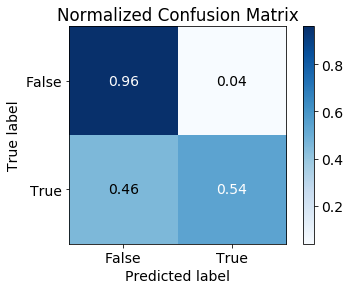

In [67]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

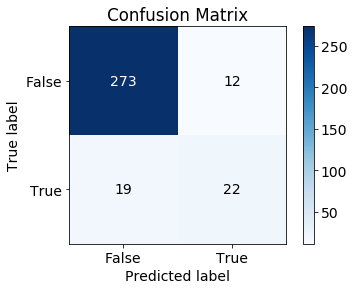

In [68]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

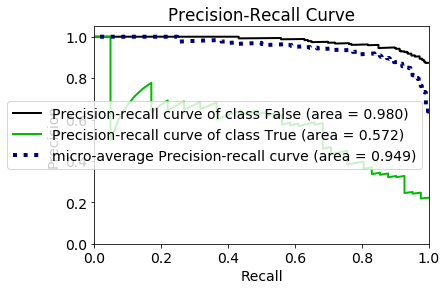

In [69]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [70]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [71]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] = df_train_fit["score"] * 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)


,epoch,loss,score
56,56,0.401755,99.433428
51,51,0.425493,99.294781
65,65,0.319586,99.292786
52,52,0.534617,99.152542
64,64,0.564860,99.147727
47,47,0.439392,99.007092
46,46,0.594035,98.873239
49,49,0.746616,98.873239
59,59,0.644990,98.870056
50,50,1.005861,98.727016


In [72]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] = df_val_fit["score"] * 100
df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
14,14,2.569562,58.666667
31,31,5.717659,56.470588
12,12,3.349443,53.658537
7,7,2.915013,53.012048
25,25,4.352235,52.873563
8,8,3.420259,52.747253
33,33,5.831715,52.380952
32,32,6.831344,52.054795
18,18,3.640208,51.948052
9,9,3.285865,51.546392


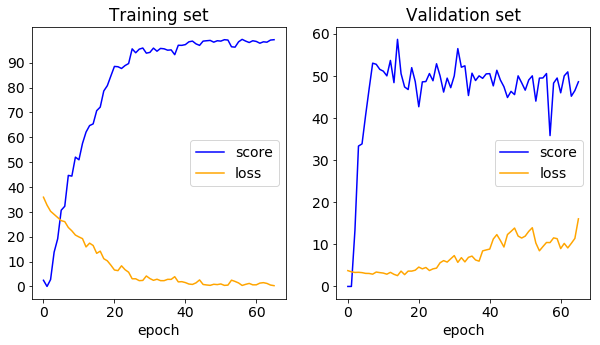

In [86]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color="orange")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator( range(0, 100, 10)))

df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color ="orange")

ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator(range(0, 100,10)))



plt.show()

### Threshold 

In [82]:
threshold = .95
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(49, 13)

In [83]:
from sklearn.metrics import f1_score, accuracy_score, precision_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)


print("The F1 score is {} and the accuracy is {}, precision {}".format(f1, accuracy, precision))

The F1 score is 0.7096774193548386 and the accuracy is 0.6326530612244898, precision 0.6470588235294118
